In [1]:
import os
import re
import sys
import yaml
import multiprocessing
import itertools
import logging

import pypsa

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerTuple

import cartopy.io.shapereader as shpreader
import pycountry
import cartopy.crs as ccrs

from scipy.spatial import ConvexHull

sns.set_theme(style="whitegrid")

# Replace __file__ with the absolute path of the notebook file
notebook_path = "/home/koen/research/eu-hydrogen/notebooks/scratch.ipynb"

# Insert ../scripts/ to sys.path
sys.path.insert(
    0, os.path.abspath(os.path.join(os.path.dirname(notebook_path), "..", "scripts"))
)

In [2]:
# Set font type: other we get type3 fonts which are problematic for ipe
mpl.rcParams["pdf.fonttype"] = 42

# Ignore INFO:fontTools logging messages
logging.getLogger("fontTools").setLevel(logging.WARNING)

In [3]:
config_fn = "../config/emission-reductions.yaml"
config = yaml.safe_load(open(config_fn))

config_default = yaml.safe_load(open("../config/config.default.yaml"))

results_dir = "../results" + (
    "/" + config["run"]["prefix"] if "prefix" in config["run"] else ""
)

scenarios_fn = config["run"]["scenarios"]["file"]
scenarios = yaml.safe_load(open(os.path.join("..", scenarios_fn)))

use_cache = False

In [4]:
green = "#5fc983"
dark_green = "#4b7559"
max_c = "#c95f7e"
min_c = "#975fc9"

titlesize = 9
textsize = 8
labelsize = 7

# cm in inch
cm = 1 / 2.54

page_width = 17.4 * cm

H2_MAX = 110

targets = [(2040, 25)]

In [5]:
def lighten_color(hex_color, amount=0.5):
    # Convert hex color to RGB
    rgb_color = mcolors.hex2color(hex_color)
    # Define white color in RGB
    white = (1, 1, 1)
    # Blend the colors
    blended_color = tuple(
        max((1 - amount) * x + amount * y, 0) for x, y in zip(rgb_color, white)
    )
    # Convert RGB to hex
    return mcolors.to_hex(blended_color)

In [6]:
stat_names = [
    "h2prod",
    "imports",
    "system_cost",
    "obj_bound_dual",
    "h2price",
    "h2value",
    "co2seq",
    "dac",
    "captured_co2",
    "elec_cap",
    "elec_cf",
    "total_onwind",
    "total_offwind",
    "total_solar",
    "total_nuclear",
    "total_h2_storage",
    "smr",
    "smr_cc",
    "ammonia_cracking",
    "bio_hydrogen",
    "fossil_gas",
    "fossil_oil",
    "demand:H2 for industry",
    "demand:land transport fuel cell",
    "demand:Fischer-Tropsch",
    "demand:H2 Fuel Cell",
    "demand:Haber-Bosch",
    "demand:Sabatier",
    "demand:hydrogen for highT industry",
    "demand:hydrogen for mediumT industry",
    "demand:methanolisation",
]


def stats(n: pypsa.Network):
    # H2
    i = n.links.loc[n.links.carrier.isin(["H2 Electrolysis"])].index
    MWh_h2 = -(
        n.links_t.p1.loc[:, i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()
    h2prod = (MWh_h2 / 33.33) / 1e6

    # Imports
    i = n.generators.loc[n.generators.index.str.contains("green import")].index
    imports = (
        n.generators_t.p.loc[:, i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum() / 1e6

    # System cost
    system_cost = n.statistics.capex().sum() + n.statistics.opex().sum()

    # System cost bound dual
    obj_bound_dual = (
        n.global_constraints.at["total_system_cost", "mu"]
        if "total_system_cost" in n.global_constraints.index
        else np.nan
    )

    # H2 price
    h2_buses = n.buses.index[n.buses.carrier == "H2"]
    h2price = (
        n.buses_t.marginal_price[h2_buses].mean(axis=1)
        * n.snapshot_weightings.generators
    ).sum() / 8760

    # Total value of H2 produced
    elec_i = n.links.index[n.links.carrier == "H2 Electrolysis"]
    h2value = -(
        n.snapshot_weightings.generators
        @ (
            n.links_t.p1[elec_i].rename(n.links.bus1, axis=1)
            * n.buses_t.marginal_price[n.links.bus1[elec_i]]
        )
    ).sum()

    # Total CO2 sequestration
    co2seq = n.stores.loc[n.stores.carrier == "co2 sequestered", "e_nom_opt"].sum()

    # Total amount of CO2 captured by DAC
    dac_i = n.links.loc[n.links.carrier == "DAC"].index
    dac = (
        n.links_t.p0.loc[:, dac_i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()

    # Total amount of CO2 captured, including industry, BECCS, etc.
    total = 0
    for i in [1, 2, 3, 4]:
        links_i = n.links.loc[n.links.__getattr__(f"bus{i}") == "co2 stored"].index
        co2 = n.links_t.__getattr__(f"p{i}").loc[:, links_i]
        co2 = co2.clip(upper=0)
        total -= (co2.sum(axis=1) * n.snapshot_weightings.generators).sum()

    captured_co2 = total / 1e6

    # Total installed capacity of electrolysers
    elec_cap = n.links.loc[elec_i, "p_nom_opt"].sum()

    # Mean capacity factor of electrolysers
    if elec_cap > 0:
        elec_cf = (
            n.links_t.p0.loc[:, elec_i].sum(axis=1) * n.snapshot_weightings.generators
        ).sum() / (elec_cap * n.snapshot_weightings.generators.sum())
    else:
        elec_cf = np.nan

    # Total installed onshore wind
    total_onwind = n.generators.loc[n.generators.carrier == "onwind", "p_nom_opt"].sum()

    # Total installed offshore wind
    total_offwind = n.generators.loc[
        n.generators.carrier.isin(["offwind-ac", "offwind-dc", "offwind-float"]),
        "p_nom_opt",
    ].sum()

    # Total installed solar
    total_solar = n.generators.loc[n.generators.carrier == "solar", "p_nom_opt"].sum()

    # Total installed nuclear
    nuclear_i = n.links.index[n.links.carrier == "nuclear"]
    total_nuclear = (
        n.links.loc[nuclear_i, "p_nom_opt"] * n.links.loc[nuclear_i, "efficiency"]
    ).sum()

    # Total installed H2 storage
    total_h2_storage = n.stores.loc[n.stores.carrier == "H2 Store", "e_nom_opt"].sum()

    # Total amount of grey H2 produced (SMR links)
    smr_i = n.links.index[n.links.carrier == "SMR"]
    smr_prod_MWh = -(
        n.links_t.p1.loc[:, smr_i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()
    smr_prod = (smr_prod_MWh / 33.33) / 1e6

    # Total amount of blue H2 produced (SMR CC links)
    smr_cc_i = n.links.index[n.links.carrier == "SMR CC"]
    smr_cc_prod_MWh = -(
        n.links_t.p1.loc[:, smr_cc_i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()
    smr_cc_prod = (smr_cc_prod_MWh / 33.33) / 1e6

    # Total amount of ammonia cracking (carrier: ammonia cracking)
    ammonia_cracking_i = n.links.index[n.links.carrier == "ammonia cracking"]
    ammonia_cracking_prod_MWh = -(
        n.links_t.p1.loc[:, ammonia_cracking_i].sum(axis=1)
        * n.snapshot_weightings.generators
    ).sum()
    ammonia_cracking_prod = (ammonia_cracking_prod_MWh / 33.33) / 1e6

    # Total amount of bio hydrogen produced (carrier: "solid biomass to hydrogen")
    bio_hydrogen_i = n.links.index[n.links.carrier == "solid biomass to hydrogen"]
    bio_hydrogen_prod_MWh = -(
        n.links_t.p1.loc[:, bio_hydrogen_i].sum(axis=1)
        * n.snapshot_weightings.generators
    ).sum()
    bio_hydrogen_prod = (bio_hydrogen_prod_MWh / 33.33) / 1e6

    oil_i = n.generators.loc[n.generators.carrier == "oil primary"].index
    fossil_oil = (n.snapshot_weightings.generators @ n.generators_t.p[oil_i]).sum()

    gas_i = n.generators.loc[n.generators.carrier == "gas"].index
    fossil_gas = (n.snapshot_weightings.generators @ n.generators_t.p[gas_i]).sum()

    # H2 demand
    h2_balance = (
        n.statistics.energy_balance(nice_names=False)
        .loc[:, :, "H2"]
        .droplevel(0, axis=0)
    )
    h2_demand = -h2_balance.loc[h2_balance < -1e5]
    h2_demand.index = "demand:" + h2_demand.index.astype(str)

    stats = {
        "h2prod": h2prod,
        "imports": imports,
        "system_cost": system_cost,
        "obj_bound_dual": obj_bound_dual,
        "h2price": h2price,
        "h2value": h2value,
        "co2seq": co2seq,
        "dac": dac,
        "captured_co2": captured_co2,
        "elec_cap": elec_cap,
        "elec_cf": elec_cf,
        "smr": smr_prod,
        "smr_cc": smr_cc_prod,
        "ammonia_cracking": ammonia_cracking_prod,
        "bio_hydrogen": bio_hydrogen_prod,
        "fossil_gas": fossil_gas,
        "fossil_oil": fossil_oil,
        "total_onwind": total_onwind,
        "total_offwind": total_offwind,
        "total_solar": total_solar,
        "total_nuclear": total_nuclear,
        "total_h2_storage": total_h2_storage,
    } | {name: h2_demand[name] for name in h2_demand.index}

    for name in stat_names:
        if name not in stats:
            stats[name] = 0

    return stats

In [7]:
if not use_cache:
    nets = {}

    # Get the overall scenario names as the top level keys in scenarios dict
    if config["run"]["name"] == "all":
        scenario_list = list(scenarios.keys())
    else:
        scenario_list = [config["run"]["name"]]

    # Assume that the following are uniquely defined for each run:
    ll = config["scenario"]["ll"][0]
    clusters = config["scenario"]["clusters"][0]
    opts = config["scenario"]["opts"][0]

    # The following are taken to vary for each run.
    sector_opts = config["scenario"]["sector_opts"]
    planning_horizons = config["scenario"]["planning_horizons"]
    slacks = config["scenario"]["slack"]
    senses = ["min", "max"]

    resolution = None

    # If resolution not none, replace all instances of "\d+seg" with resolution in sector_opts
    if resolution is not None:
        sector_opts = [
            re.sub(r"\d+seg", resolution, s) if "seg" in s else s + "-" + resolution
            for s in sector_opts
        ]

    def load_stats(file):
        return (
            stats(pypsa.Network(file))
            if os.path.exists(file)
            else {v: np.nan for v in stat_names}
        )

    index = list(
        itertools.product(scenario_list, sector_opts, planning_horizons, slacks, senses)
    )
    index_opt = list(
        itertools.product(scenario_list, sector_opts, planning_horizons, [0], ["opt"])
    )

    with multiprocessing.Pool(30) as pool:
        networks = pool.map(
            load_stats,
            [
                f"{results_dir}/{s}/postnetworks/base_s_{clusters}_l{ll}_{opts}_{o}_{h}_{sense}{slack}.nc"
                for s, o, h, slack, sense in index
            ],
        )

        networks.extend(
            pool.map(
                load_stats,
                [
                    f"{results_dir}/{s}/postnetworks/base_s_{clusters}_l{ll}_{opts}_{o}_{h}.nc"
                    for s, o, h, _, _ in index_opt
                ],
            )
        )

    networks = dict(zip(index + index_opt, networks))

/fp/homes01/u01/ec-koenvg/.conda/envs/my_base/envs/eu-hydrogen-new/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=416362) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/fp/homes01/u01/ec-koenvg/.conda/envs/my_base/envs/eu-hydrogen-new/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=416362) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/fp/homes01/u01/ec-koenvg/.conda/envs/my_base/envs/eu-hydrogen-new/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=416362) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/fp/homes01/u01/ec-koenvg/.conda/envs/my_base/envs/eu-hydrogen-new/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=416362) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.

INFO:pypsa.io:Imported network base_s_50_lc1.5__Cb-Ia-Eb-Tb_2050_min0.1.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_50_lc1.5__Cb-Ia-Ea-Tb_2030_min0.05.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_50_lc1.5__Ca-Ia-Ea-Tb_2025_min0.02.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_50_lc1.5__Ca-Ib-Ea-Tb_2025_min0.05.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_50_lc1.5__Cb-Ib-Ea-Tb_2050_min0.05.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_50_lc1.5__Cb-Ia-Ea-Tb_2050_min0.02.nc has buses, carriers, generators, global_constraints, lines, links

In [8]:
if not use_cache:
    display(pd.DataFrame(networks).T.reset_index())

,level_0,level_1,level_2,level_3,level_4,h2prod,imports,system_cost,obj_bound_dual,h2price,...,total_h2_storage,demand:Haber-Bosch,demand:methanolisation,demand:H2 for industry,demand:land transport fuel cell,demand:Fischer-Tropsch,demand:H2 Fuel Cell,demand:Sabatier,demand:hydrogen for highT industry,demand:hydrogen for mediumT industry
0,baseline,Ca-Ia-Ea-Tb,2025,0.02,min,-0.000000e+00,4.516074e-11,9.750040e+11,NaN,59.273589,...,0.140184,9.809633e+07,3.284259e+07,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
1,baseline,Ca-Ia-Ea-Tb,2025,0.02,max,3.794769e+00,1.440439e-06,9.896291e+11,-12.514007,0.511379,...,0.225022,9.809633e+07,3.284260e+07,0.0,0.000000e+00,3.870726e+06,0.0,0.0,0.0,0.0
2,baseline,Ca-Ia-Ea-Tb,2025,0.05,min,-0.000000e+00,5.825028e-11,9.750040e+11,NaN,59.278195,...,0.180627,9.809633e+07,3.284259e+07,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
3,baseline,Ca-Ia-Ea-Tb,2025,0.05,max,8.511056e+00,9.592950e-08,1.011567e+12,-12.082535,0.465756,...,0.024626,9.809633e+07,3.284259e+07,0.0,0.000000e+00,1.610646e+08,0.0,0.0,0.0,0.0
4,baseline,Ca-Ia-Ea-Tb,2025,0.10,min,-0.000000e+00,4.549819e-12,9.750040e+11,NaN,59.271601,...,0.029531,9.809633e+07,3.284259e+07,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,slow,Cc-Ib-Eb-Tb,2030,0.00,opt,3.266715e-07,2.010394e+00,9.328603e+11,NaN,82.118092,...,6649.728276,9.578761e+07,3.284259e+07,0.0,6.757899e+06,0.000000e+00,0.0,0.0,0.0,0.0
1508,slow,Cc-Ib-Eb-Tb,2035,0.00,opt,1.753676e-03,3.705904e+01,8.471247e+11,NaN,79.661741,...,64585.820615,9.539285e+07,3.284259e+07,19440000.0,6.588951e+07,0.000000e+00,0.0,0.0,0.0,0.0
1509,slow,Cc-Ib-Eb-Tb,2040,0.00,opt,1.276820e-03,1.427541e+02,7.890811e+11,NaN,69.679263,...,101108.545881,9.357802e+07,3.284259e+07,39860000.0,1.233317e+08,0.000000e+00,0.0,0.0,0.0,0.0
1510,slow,Cc-Ib-Eb-Tb,2045,0.00,opt,1.037625e-03,2.456325e+02,7.656373e+11,NaN,65.173703,...,235268.703410,9.499778e+07,3.284259e+07,64200000.0,2.145633e+08,0.000000e+00,0.0,0.0,0.0,0.0


In [9]:
if not use_cache:
    df = pd.DataFrame(networks).T.reset_index()
    df.rename(
        columns={
            "level_0": "emission_reduction",
            "level_1": "opts",
            "level_2": "horizon",
            "level_3": "slack",
            "level_4": "sense",
        },
        inplace=True,
    )

    # Strip any suffix of the form "-\d+seg" from the "opts" column
    df["opts"] = df["opts"].str.replace(r"-\d+seg", "", regex=True)

    # The "opts" column has the form "XX-YY-ZZ-..."; we want to split this into separate columns and keep only the last character
    flags = list(map(lambda s: s[0], df.at[0, "opts"].split("-")))
    df[flags] = df["opts"].str.split("-", expand=True).map(lambda s: s[-1])
    df.drop(columns=["opts"], inplace=True)

    # Add a column concatenating the year and flags
    df["scenario"] = (
        df["emission_reduction"] + df[flags].apply(lambda x: "".join(x), axis=1)
    )

    # Now set the index to the scenario, year, flags, slack and horizon
    df.set_index(
        ["scenario", "emission_reduction"] + flags + ["sense", "slack", "horizon"], inplace=True
    )

    df.to_csv(f"cache_{results_dir.split('/')[-1]}.csv")

    display(df)
else:
    fn = f"cache_{results_dir.split('/')[-1]}.csv"
    cols = pd.read_csv(fn).columns
    df = pd.read_csv(fn, index_col=list(range(len(cols) - len(stat_names))))

    # Convert "year" index level values from int to str
    df.index = df.index.set_levels(df.index.levels[1].astype(str), level=1)

    display(df)

h2prod  \
scenario     emission_reduction C I E T sense slack horizon                 
baselineaaab baseline           a a a b min   0.02  2025    -0.000000e+00   
                                        max   0.02  2025     3.794769e+00   
                                        min   0.05  2025    -0.000000e+00   
                                        max   0.05  2025     8.511056e+00   
                                        min   0.10  2025    -0.000000e+00   
...                                                                   ...   
slowcbbb     slow               c b b b opt   0.00  2030     3.266715e-07   
                                                    2035     1.753676e-03   
                                                    2040     1.276820e-03   
                                                    2045     1.037625e-03   
                                                    2050     9.977748e-04   

                                                                  imports  \
scenario     emission_reduction C I E T sense slack horizon                 
baselineaaab baseline           a a a b min   0.02  2025     4.516074e-11   
                                        max   0.02  2025     1.440439e-06   
                                        min   0.05  2025     5.825028e-11   
                                        max   0.05  2025     9.592950e-08   
                                        min   0.10  2025     4.549819e-12   
...                                                                   ...   
slowcbbb     slow               c b b b opt   0.00  2030     2.010394e+00   
                                                    2035     3.705904e+01   
                                                    2040     1.427541e+02   
                                                    2045     2.456325e+02   
                                                    2050     3.489550e+02   

                                                              system_cost  \
scenario     emission_reduction C I E T sense slack horizon                 
baselineaaab baseline           a a a b min   0.02  2025     9.750040e+11   
                                        max   0.02  2025     9.896291e+11   
                                        min   0.05  2025     9.750040e+11   
                                        max   0.05  2025     1.011567e+12   
                                        min   0.10  2025     9.750040e+11   
...                                                                   ...   
slowcbbb     slow               c b b b opt   0.00  2030     9.328603e+11   
                                                    2035     8.471247e+11   
                                                    2040     7.890811e+11   
                                                    2045     7.656373e+11   
                                                    2050     7.350334e+11   

                                                             obj_bound_dual  \
scenario     emission_reduction C I E T sense slack horizon                   
baselineaaab baseline           a a a b min   0.02  2025                NaN   
                                        max   0.02  2025         -12.514007   
                                        min   0.05  2025                NaN   
                                        max   0.05  2025         -12.082535   
                                        min   0.10  2025                NaN   
...                                                                     ...   
slowcbbb     slow               c b b b opt   0.00  2030                NaN   
                                                    2035                NaN   
                                                    2040                NaN   
                                                    2045                NaN   
                                                    2050                NaN   

                                 

# Plots

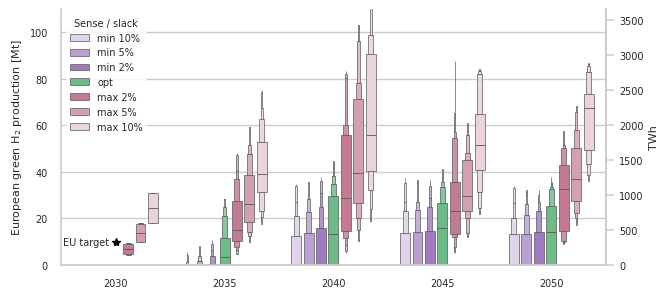

In [10]:
fig, ax = plt.subplots(
    figsize=(page_width, 8 * cm),
    layout="tight",
)

df_sel = df.copy()

# Add new index to df_sel; concatenation of sense and slack index levels
df_sel["hue"] = df_sel.index.get_level_values("sense") + df_sel.index.get_level_values(
    "slack"
).map(lambda x: f"_{x:.2f}")

palette = {"opt_0.00": green}
lighten = {0.0: 0, 0.02: 0.1, 0.05: 0.35, 0.10: 0.7}
for slack in df.index.get_level_values("slack").unique():
    palette[f"min_{slack:.2f}"] = lighten_color(min_c, lighten[slack])
    palette[f"max_{slack:.2f}"] = lighten_color(max_c, lighten[slack])

sns.boxenplot(
    data=df_sel,
    x="horizon",
    y="h2prod",
    hue="hue",
    width_method="exponential",
    k_depth="full",
    hue_order=[
        "min_0.10",
        "min_0.05",
        "min_0.02",
        "opt_0.00",
        "max_0.02",
        "max_0.05",
        "max_0.10",
    ],
    palette=palette,
    orient="v",
    gap=0.2,
    linewidth=0.5,
    native_scale=True,
    ax=ax,
)

# Format legend items nicely; "min_0.05" -> "5% min."; "opt_0.00" -> "Optimum"
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=[
        (
            "opt"
            if "opt" in l
            else f"{l.split('_')[0]} {int(float(l.split('_')[1]) * 100)}%"
        )
        for l in labels
    ],
    fontsize=labelsize,
    title="Sense / slack",
    title_fontsize=labelsize,
    loc="upper left",
    edgecolor="none",
)

ax.set_ylim(0, H2_MAX)
ax.set_xlim(2027.5, 2052.5)

# Turn off x-grid
ax.xaxis.grid(False)

# Turn off spines
ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)

# Set ticks at every 5 years
ax.xaxis.set_major_locator(plt.MultipleLocator(5))

# Tick size
ax.tick_params(axis="both", which="major", labelsize=labelsize)

# Set labels
ax.set_ylabel("European green H$_2$ production [Mt]", fontsize=textsize)
ax.set_xlabel(None)

# Add black star marker at (2030, 10) to indicate EU target, and annotate
ax.plot(2030, 10, marker="*", color="black", markersize=6, clip_on=False)
ax.text(2029.7, 10, "EU target", va="center", ha="right", size=labelsize)

# Add second y axis with TWh (where 1 Mt H2 = 33.3 TWh)
ax2 = ax.secondary_yaxis("right", functions=(lambda x: x * 33.3, lambda x: x / 33.3))
# Label, tick parameters
ax2.set_ylabel("TWh", fontsize=textsize)
# Set color of tick marks (but not of text) to lightgrey
ax2.tick_params(axis="y", which="major", labelsize=labelsize, color="lightgrey")

In [11]:
def intersection_by_quantile(data, q):
    lower = pd.Series(index = data.index.get_level_values("horizon").unique())
    upper = pd.Series(index = data.index.get_level_values("horizon").unique())
    for h in data.index.get_level_values("horizon").unique():
        interval_boundaries = data.xs(h, level="horizon").h2prod.sort_values().dropna().unique()
        if len(interval_boundaries) < 2:
            continue
        density = pd.Series(
            index=pd.IntervalIndex.from_breaks(interval_boundaries, closed="left"), dtype=float
        )
        data_unstacked = data.xs(h, level="horizon").h2prod.unstack("sense").dropna()
        if len(data_unstacked) == 0:
            continue
        mids = np.array(density.index.mid)
        max_vals = data_unstacked["max"].values
        min_vals = data_unstacked["min"].values
        denom = len(data_unstacked)
        # Use broadcasting to count rows satisfying the condition for each mid
        counts = ((max_vals[np.newaxis, :] > mids[:, np.newaxis]) &
              (min_vals[np.newaxis, :] < mids[:, np.newaxis])).sum(axis=1)
        density[:] = counts / denom

        if len(density[density >= q]) > 0:
            lower[h] = density.index[density >= q].min().left
            upper[h] = density.index[density >= q].max().right
        else:
            # If no intersection, set lower and upper to mid of interval with maximum density
            lower[h] = density.idxmax().mid
            upper[h] = density.idxmax().mid

    return lower, upper

In [12]:
# Plot bands representing the range between maximum green hydrogen production
# over scenarios in cost (sense) minimisation, and minimum production over
# scenarios in cost maximisation (for each slack level)

robust_colour = "#5dc4ad"
target_colour = "#864da3"


quantile_colors = {
    1: robust_colour,
    0.9: lighten_color(robust_colour, 0.25),
    0.8: lighten_color(robust_colour, 0.5),
    0.7: lighten_color(robust_colour, 0.75),
}


def plot_robust_ranges(data, quantiles, slack, ax, plot_targets=True, max_y=50):
    for q in quantiles:
        lower, upper = intersection_by_quantile(data.xs(slack, level="slack").copy(), q)
        ax.fill_between(
            lower.index,
            lower,
            upper,
            color=quantile_colors[q],
            edgecolor="none",
            label=None,
            zorder=-1,
        )

    # Plot median cost-optimal pathway
    sns.lineplot(
        data=data.xs("opt", level="sense"),
        x="horizon",
        y="h2prod",
        color=dark_green,
        linewidth=2,
        linestyle="--",
        estimator=np.median,
        errorbar=None,
        ax=ax,
    )

    # Add black star marker at (2030, 10) to indicate EU target, and annotate
    ax.plot(
        2030,
        10,
        marker="*",
        color="black",
        markersize=8,
        clip_on=False,
        label="EU target",
        linewidth=0,
    )

    # Add star markers to indicate proposed targets
    if plot_targets:
        ax.plot(
            targets[0][0],
            targets[0][1],
            marker="*",
            color=target_colour,
            markersize=8,
            clip_on=False,
            label="Proposed target",
            linewidth=0,
        )
        if len(targets) > 1:
            ax.plot(
                targets[1][0],
                targets[1][1],
                marker="*",
                color=target_colour,
                markersize=8,
                clip_on=False,
            )

    ax.set_xlim(2030, 2050)
    ax.set_ylim(0, max_y)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Put y grid in front of the plot (zorder)
    ax.yaxis.grid(True, which="major", linestyle="--", linewidth=1, zorder=10)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set ticks at every 5 years
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))

    # Tick size
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    # Set labels
    ax.set_xlabel(None)

    # Right-justify the tick label that says "2050" in axs[0]
    for tick in ax.xaxis.get_majorticklabels():
        if tick.get_text() == "2050":
            tick.set_horizontalalignment("right")

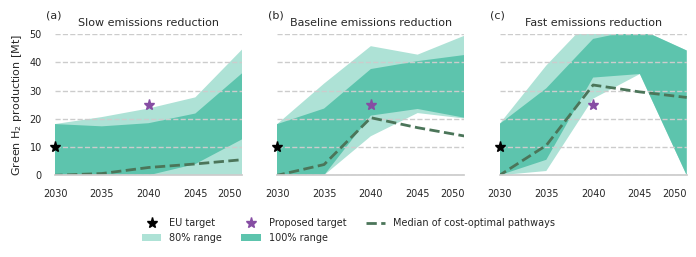

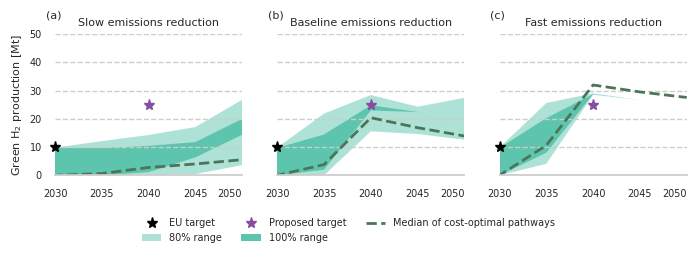

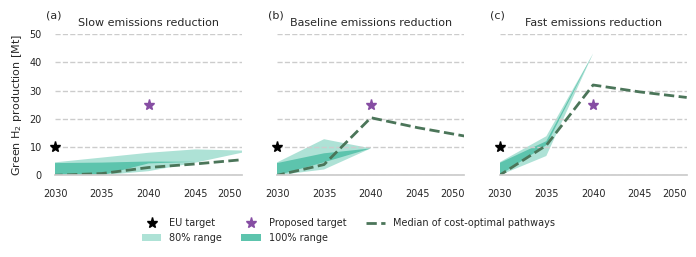

In [17]:
for slack_level in [0.1, 0.05, 0.02]:
    ncols = 3
    fig, axs = plt.subplots(
        1,
        ncols,
        figsize=(page_width, 5 * cm),
        sharey=True,
        layout="constrained",
        gridspec_kw={"hspace": 0.1, "wspace": 0.1},
    )

    quantiles = [0.8, 1]

    settings = {
        "slow": {"emission_reduction": "slow"},
        "baseline": {"emission_reduction": "baseline"},
        "fast": {"emission_reduction": "fast"},
        # "all": {},
        # "unlimited_imports": {"I": "b"},
        # "optimistic_CCS": {"C": ["b", "c"]},
    }
    pretty_labels = {
        "slow": "Slow emissions reduction",
        "baseline": "Baseline emissions reduction",
        "fast": "Fast emissions reduction",
        # "all": "All scenarios",
        # "unlimited_imports": "Imports: unlimited",
        # "optimistic_CCS": "CCS: baseline or optimistic\nTransport elec.: baseline",
    }

    for ax, setting in zip(axs.flatten(), settings.values()):
        df_selection = df.copy()
        for level, value in setting.items():
            if isinstance(value, list):
                df_selection = df_selection.loc[
                    df_selection.index.get_level_values(level).isin(value)
                ]
            else:
                df_selection = df_selection.xs(value, level=level)
        plot_robust_ranges(
            df_selection,
            quantiles,
            slack_level,
            ax,
        )

    # for ax in axs[:, 0]:
    axs[0].set_ylabel("Green H$_2$ production [Mt]", fontsize=textsize)

    ax = axs.flatten()[0]

    # Add a single legend underneath middle plot, with two entries: "Proposed targets" and "Cost-optimal pathway".
    # Have to make manual phantom line to get the legend to show the dashed line
    handles, labels = ax.get_legend_handles_labels()
    labels.append("Median of cost-optimal pathways")
    handles.append(ax.plot([], [], color=dark_green, linestyle="--", linewidth=2)[0])
    # Also add patches with quantile shading
    for q in quantiles:
        labels.append(f"{q:.0%} range")
        handles.append(
            ax.fill_between([], [], color=quantile_colors[q], edgecolor="none"),
        )
    # Reorder labels to put quantile shadings as every second item (bottom row)
    legend_cols = 3
    hl = list(zip(handles, labels))
    hl = sum([hl[i::legend_cols] for i in range(legend_cols)], [])

    fig.legend(
        *zip(*hl),
        loc="lower center",
        fontsize=labelsize,
        ncol=legend_cols,
        frameon=False,
        bbox_to_anchor=(0.5, -0.25),
    )

    # Plot titles
    for ax, setting in zip(axs.flatten(), settings):
        ax.set_title(pretty_labels[setting], fontsize=textsize)

    # Annotate the top left corner of each subplot with (a), (b), (c), etc.
    for i, ax in enumerate(axs.flatten()):
        ax.annotate(
            "(" + chr(97 + i) + ")",
            xy=(-0.05, 1.1),
            xycoords="axes fraction",
            fontsize=textsize,
            ha="left",
            va="bottom",
        )

    fig.savefig(
        f"figures/robustness_emission_reductions_{slack_level}.pdf",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )

    plt.show()

In [14]:
# Just print the ranges for the core robust pathways (i.e. quantile=1)
df_copy = df.xs(0.1, level="slack").copy()
lower = df_copy.xs("min", level="sense").groupby(["horizon"])["h2prod"].max()
upper = df_copy.xs("max", level="sense").groupby(["horizon"])["h2prod"].min()
display(pd.concat([lower, upper], axis=1, keys=["min", "max"]).round(1))

,min,max
horizon,,
2025,-0.0,16.2
2030,-0.0,18.1
2035,5.5,17.3
2040,34.6,18.4
2045,37.2,21.9
2050,33.7,36.2


In [15]:
df.xs("opt", level="sense").groupby("horizon")["h2prod"].median().round(1)

horizon
2025     0.0
2030     0.0
2035     3.3
2040    13.1
2045    15.7
2050    14.1
Name: h2prod, dtype: float64

In [16]:
# Number (and percentage) of successful optimisations

num_nan = df.h2prod.groupby(["horizon", "sense", "slack"]).apply(
    lambda x: x.isna().sum()
).unstack("horizon").astype(int)
num_tot = df.h2prod.groupby(["horizon", "sense", "slack"]).apply(
    lambda x: len(x)
).unstack("horizon").astype(int)


display(num_nan)

display((num_nan / num_tot).round(2) * 100)

horizon      2025  2030  2035  2040  2045  2050
sense slack                                    
max   0.02      0     0     0     0    10    12
      0.05      0     0     0     0    14    15
      0.10      0     0     0     0    13    15
min   0.02      0     0     0     0     0     0
      0.05      0     0     0     0     0     0
      0.10      0     0     0     0     0     0
opt   0.00      0     0     0     0     0     0

horizon      2025  2030  2035  2040  2045  2050
sense slack                                    
max   0.02    0.0   0.0   0.0   0.0  28.0  33.0
      0.05    0.0   0.0   0.0   0.0  39.0  42.0
      0.10    0.0   0.0   0.0   0.0  36.0  42.0
min   0.02    0.0   0.0   0.0   0.0   0.0   0.0
      0.05    0.0   0.0   0.0   0.0   0.0   0.0
      0.10    0.0   0.0   0.0   0.0   0.0   0.0
opt   0.00    0.0   0.0   0.0   0.0   0.0   0.0